# Credibility Sets

**Created**: 4 February 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [2]:
geno <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim") %>%
    as.data.frame()
colnames(geno) <- c("chr", "snp", "cM", "pos", "minor", "major")

In [3]:
head(geno)

,chr,snp,cM,pos,minor,major
,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,1,rs3131972,0,817341,A,G
2,1,rs546843995,0,818053,0,G
3,1,rs553916047,0,818359,0,A
4,1,1:818740_T_C,0,818740,T,C
5,1,rs145604921,0,819378,0,C
6,1,rs535256652,0,821053,0,T


In [4]:
cis.eqtl.conditional <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/conditionalanalysis/conditional_eQTL_results_final.rds")

cis.eqtl.conditional <- cis.eqtl.conditional %>%
    dplyr::mutate(SNP=gsub("\\.", ":", SNP)) %>%
    merge(., geno, by.x="SNP", by.y="snp") %>%
    dplyr::select(snps=SNP, gene=Gene, pvalue, beta=eQTL_beta, se=eQTL_SE, chr, SNPpos=pos, Conditional.Number=Number) %>%
    dplyr::mutate(pvalue=as.numeric(pvalue)) %>%
    dplyr::mutate(beta=as.numeric(beta)) %>%
    dplyr::mutate(se=as.numeric(se)) %>%
    dplyr::mutate(chr=as.numeric(chr))

In [5]:
head(cis.eqtl.conditional)

,snps,gene,pvalue,beta,se,chr,SNPpos,Conditional.Number
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,5:54079901_A_C,ENSG00000272416,1.905358e-05,0.13545826,0.031504093,5,54079901,1
2,rs10000507,ENSG00000164305,1.194703e-05,-0.05880549,0.013312181,4,184698127,1
3,rs10000850,ENSG00000128039,7.576675e-43,-0.64265343,0.043284640,4,55634211,2
4,rs1000137,ENSG00000272839,1.261994e-13,-0.17162745,0.022657505,7,157851460,1
5,rs10001795,ENSG00000121892,2.088410e-05,-0.03630321,0.008460434,4,40366982,4
6,rs10004630,ENSG00000170390,1.804495e-17,0.12054523,0.013573487,4,150065588,1


In [14]:
susie.snps <- lapply(1:22, function(chr) {
    read.table(paste0("~/gains_team282/nikhil/colocalization/cis_eqtl/fine_mapping/SuSiE/chr", chr, "_credible_sets.tsv"), sep="\t", header=T)
}) %>% do.call(rbind, .) %>%
    as.data.frame() %>%
    merge(., geno, by.x="SNP", by.y="snp") %>%
    dplyr::filter(is.na(Notes)) %>%
    dplyr::mutate(chr=as.numeric(chr))

In [15]:
head(susie.snps)

,SNP,Gene,SNP_Prob,Credible_Set,Notes,chr,cM,pos,minor,major
,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>
1,rs10000015,ENSG00000250057,0.034726133,2,NA,4,0,83222834,G,A
2,rs10000245,ENSG00000174720,0.010205481,5,NA,4,0,111649891,G,A
3,rs10000247,ENSG00000163104,0.003358885,1,NA,4,0,94252099,G,C
4,rs10000679,ENSG00000150625,0.023335859,7,NA,4,0,176749810,G,T
5,rs10000860,ENSG00000250673,0.331596520,9,NA,4,0,146158574,C,T
6,rs10000860,ENSG00000279845,0.067877224,2,NA,4,0,146158574,C,T


## SuSiE Credible Sets

Of the 10618 eGenes detected in the cohort, 9242 have at least one credibility set.

In [16]:
length(unique(susie.snps$Gene))
length(unique(cis.eqtl.conditional$gene))

[1] 9242

[1] 10618

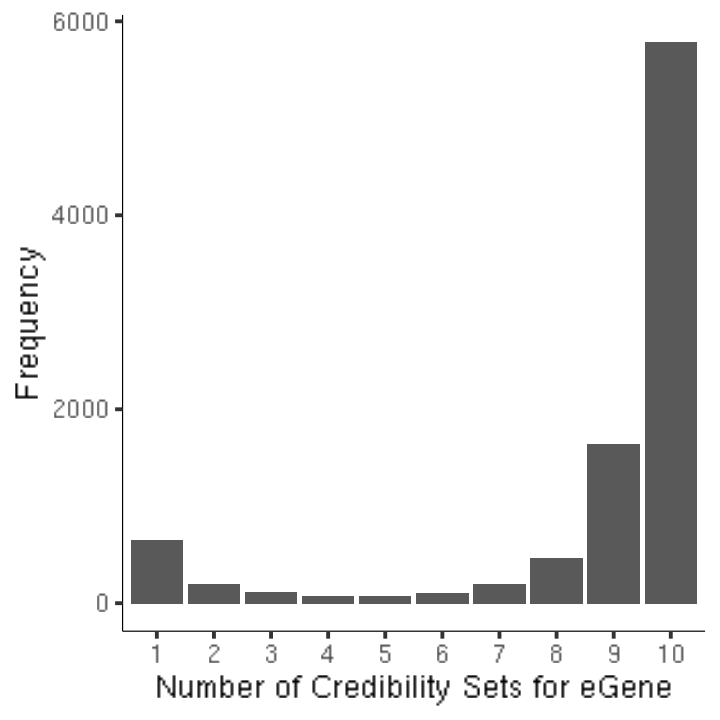

In [17]:
options(repr.plot.width=6, repr.plot.height=6)

susie.snps %>%
    dplyr::group_by(Gene) %>%
    dplyr::summarize(N.CS=length(unique(Credible_Set))) %>%
    dplyr::mutate(N.CS=factor(N.CS, levels=1:(max(N.CS)))) %>%
    ggplot() +
    geom_bar(aes(x=N.CS)) +
    xlab("Number of Credibility Sets for eGene") + ylab("Frequency") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/susie_number_of_credibility_sets.svg", width=6, height=6)

eGenes that do not have credibility sets tend to have less significant associations.

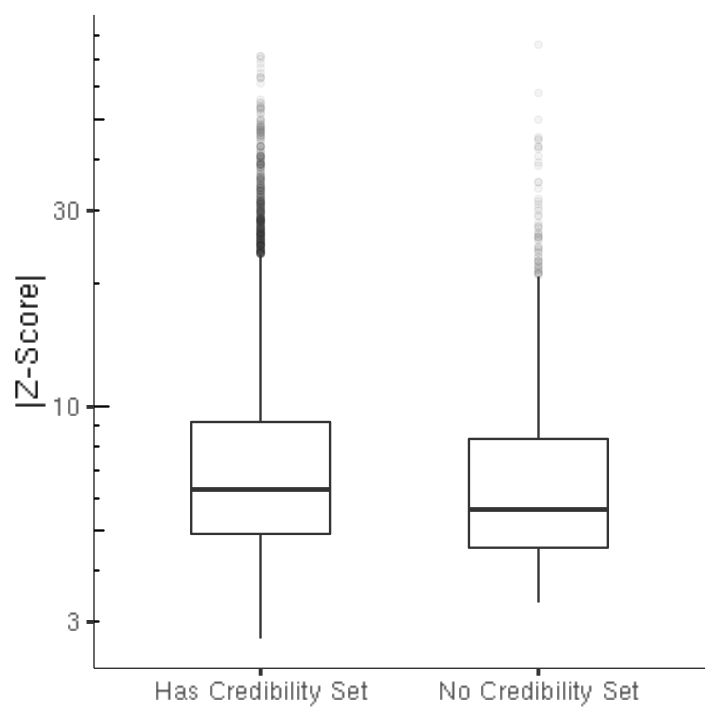

In [18]:
options(repr.plot.width=6, repr.plot.height=6)

cis.eqtl.conditional %>%
    dplyr::mutate(Has.CS=ifelse(gene %in% susie.snps$Gene, "Has Credibility Set", "No Credibility Set")) %>%
    dplyr::mutate(Abs.Z.Score=abs(beta / se)) %>%
    ggplot() +
    geom_boxplot(aes(x=Has.CS, y=Abs.Z.Score), width=0.5, outlier.alpha=0.05) +
    scale_y_log10() + annotation_logticks(sides="l") +
    ylab("|Z-Score|") +
    ggplot_theme +
    theme(axis.title.x=element_blank())

ggsave("03_Functional_Interpretation/results/susie_z_scores_by_credibility_set.svg", width=6, height=6)

## Lead and Sentinel SNPs in Credibility Sets

In [19]:
length(unique(cis.eqtl.conditional$gene))

[1] 10618

For a given eGene, is the number of credibility sets detected the same as the number of conditional signals detected?

In [20]:
cond.signals <- sapply(
    split(cis.eqtl.conditional, cis.eqtl.conditional$gene),
    function(locus) {
        length(unique(locus$Conditional.Number))
    }
) %>% as.matrix() %>%
    as.data.frame() %>%
    dplyr::mutate(Gene=rownames(.)) %>%
    dplyr::select(Gene, N.Conditional.Signals=1)

In [21]:
susie.cs <- sapply(
    split(susie.snps, susie.snps$Gene),
    function(locus) {
        length(unique(locus$Credible_Set))
    }
) %>% as.matrix() %>%
    as.data.frame() %>%
    dplyr::mutate(Gene=rownames(.)) %>%
    dplyr::select(Gene, N.CS=1)

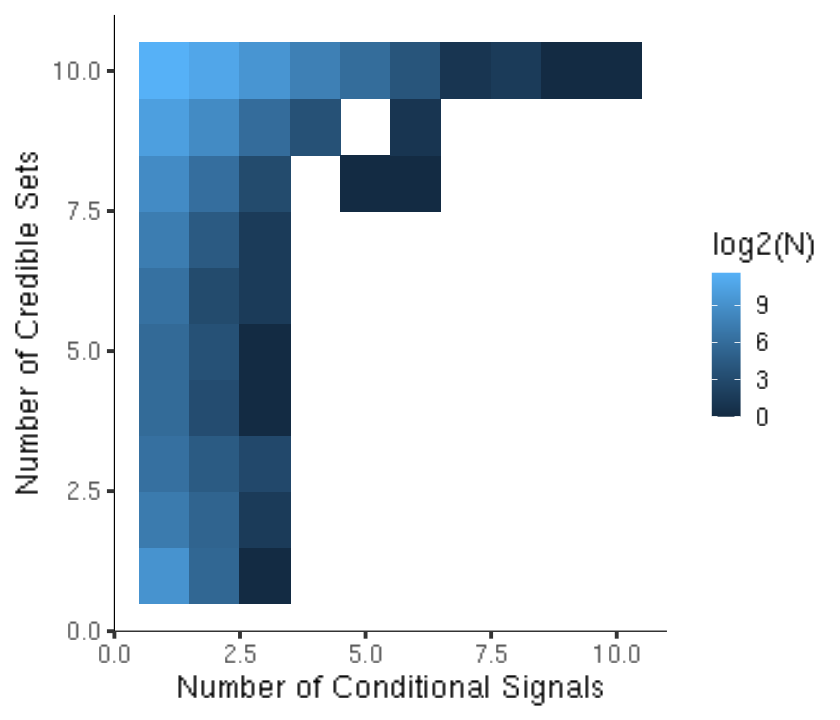

In [22]:
options(repr.plot.width=7, repr.plot.height=6)

merge(cond.signals, susie.cs, by="Gene") %>%
    dplyr::group_by(N.Conditional.Signals, N.CS) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    ggplot() +
    geom_tile(aes(x=N.Conditional.Signals, y=N.CS, fill=log2(N))) +
    xlab("Number of Conditional Signals") + ylab("Number of Credible Sets") +
    ggplot_theme +
    theme(legend.position="right")

ggsave("03_Functional_Interpretation/results/susie_overlap_of_signals_with_conditional_analysis.svg", width=7, height=6)

For a given eGene, how many of the sentinel SNPs are present in a credibility set? Of the 16468 eGene-SNP pairs, 11449 are covered by a credibility set.

In [136]:
merge(
    cis.eqtl.conditional %>%
        dplyr::mutate(eSNP=paste0(gene, ":", snps)),
    susie.snps %>%
        dplyr::mutate(eSNP=paste0(Gene, ":", SNP)),
    by="eSNP"
) %>%
    nrow()

[1] 11449

In [132]:
nrow(cis.eqtl.conditional)

[1] 16468